# Topic Models for Buffer Strip Research

In this script we run some topic models on the dataset and view the results in a couple of ways

Parts of this script are based on the sklearn topic model example found at https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [1]:
import pandas as pd
import numpy as np

## First we load the dataset and do some cleaning

In [2]:
df = pd.read_csv('data/20201215_EGM_Net_all-articles_clean.csv', encoding= 'unicode_escape')
print(df.shape)
print(df.columns)

missings = df[pd.isna(df['Abstract'])].index
print(f"Removing {missings.shape[0]} with missing Abstract")
df = df[~df.index.isin(missings)].reset_index(drop=True)

# clean the abstract text to remove copyright and other procedural parts
df['Abstract'] = df['Abstract'].str.replace("(\(C).*","",regex=True)
df['Abstract'] = df['Abstract'].str.replace("(\[C).*","",regex=True)
df['Abstract'] = df['Abstract'].str.replace("(Elsevier Science).*","",regex=True)
df['Abstract'] = df['Abstract'].str.replace("^Abstract:","",regex=True)
df['Abstract'] = df['Abstract'].str.replace("(\[ABSTRACT).*","",regex=True)
df['Abstract'] = df['Abstract'].str.replace("Copyright.*","",regex=True)



df.head()

(1019, 16)
Index(['ID', 'Zotero_Key', 'Item_Type', 'Pub_Year', 'Authors', 'Authors_Clean',
       'Title', 'Source', 'ISBN', 'ISSN', 'DOI', 'Url', 'Abstract', 'Pages',
       'Volume', 'Manual_Tags'],
      dtype='object')
Removing 203 with missing Abstract


,ID,Zotero_Key,Item_Type,Pub_Year,Authors,Authors_Clean,Title,Source,ISBN,ISSN,DOI,Url,Abstract,Pages,Volume,Manual_Tags
0,590,WC2BD8TZ,journalArticle,2004,"MacLeod, A.|Wratten, S. D.|Sotherton, N. W.|Th...",MacLeod A.|Wratten S. D.|Sotherton N. W.|Thoma...,'beetle banks' as refuges for beneficial arthr...,Agricultural and Forest Entomology,NaN,1461-9555,10.1111/j.1461-9563.2004.00215.x,://WOS:000221413300008,1 Significant differences in the overwintering...,147-154,6,eppi-reviewer4
1,895,2CJAYP5V,journalArticle,2015,"Szajdak Lech, Wojciech|Maryganova, Victoria|Sk...",Szajdak L. W.|Maryganova V.|Skakovskii E.|Tych...,1h and 13c nmr spectroscopic studies of hexane...,Chemosphere,NaN,456535,10.1016/j.chemosphere.2014.10.032,https://ezp.sub.su.se/login?url=http://search....,Comparative study of the composition of lipids...,1422-1427,119,"eppi-reviewer4; WINDBREAKS, shelterbelts, etc...."
2,577,UWDGTDQZ,journalArticle,2006,"Ludy, C.|Lang, A.",Ludy C.|Lang A.,a 3-year field-scale monitoring of foliage-dwe...,Biological Control,NaN,10499644,10.1016/j.biocontrol.2006.05.010,https://ezp.sub.su.se/login?url=http://search....,Concerns have been raised that genetically mo...,314-324,38,GERMANY; eppi-reviewer4; Arthropod predators; ...
3,183,2QCB9ZPL,journalArticle,2003,"Collins, K. L.|Boatman, N. D.|Wilcox, A.|Holla...",Collins K. L.|Boatman N. D.|Wilcox A.|Holland ...,a 5-year comparison of overwintering polyphago...,Annals of Applied Biology,NaN,Mar-46,10.1111/j.1744-7348.2003.00063.x,://WOS:000184640600008,Overwintering polyphagous predator density and...,63-71,143,eppi-reviewer4
4,209,3Q8IHLK6,journalArticle,2002,"Croxton, P. J.|Carvell, C.|Mountford, J. O.|Sp...",Croxton P. J.|Carvell C.|Mountford J. O.|Spark...,a comparison of green lanes and field margins ...,Biological Conservation,NaN,NaN,10.1016/S0006-3207(02)00074-5,http://www.scopus.com/inward/record.url?eid=2-...,There have been major changes in agricultural ...,365-374,107,Bees; eppi-reviewer4; Hedgerows; Farmland; Fie...


## Now we tokenize the abstracts, creating a matrix of documents and the scores for each feature in our vocabulary

Tfidf vectorization weights features according to how infrequent they are in the dataset, so that common features have a smaller influence

In [3]:
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from nltk.stem import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

def tokenize(text):
    transtable = {ord(c): None for c in string.punctuation + string.digits}
    tokens = nltk.word_tokenize(text.translate(transtable))
    tokens = [i for i in tokens if len(i) > 2 and len(i) < 100]
    return tokens

class snowball_stemmer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer("english")
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in tokenize(doc)]

tokenizer = snowball_stemmer()
stoplist = set(nltk.corpus.stopwords.words("english"))

# Extracting tf-idf features for NMF
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, stop_words="english", ngram_range=(1,2),
    tokenizer=tokenizer
)
tfidf = tfidf_vectorizer.fit_transform(df['Abstract'])


# Use tf (raw term count) features for LDA.
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, stop_words="english"
)
tf = tfidf_vectorizer.fit_transform(df['Abstract'])
tf.shape

/home/max/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/max/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'ver

(816, 13723)

In [4]:
# Here's a function to plot the results of a topic model, it returns a list of titles which are simply the top 3 words of each topic 

def plot_top_words(model, feature_names, n_top_words, title, n_components):
    fig, axes = plt.subplots(n_components//5+1,5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    t_titles = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
        
        t_titles.append(", ".join(top_features[:3]))

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    
    return t_titles

## Below we run our first topic model and view the terms associated with each topic

we can alter the number of topics by setting the `n_components` variable

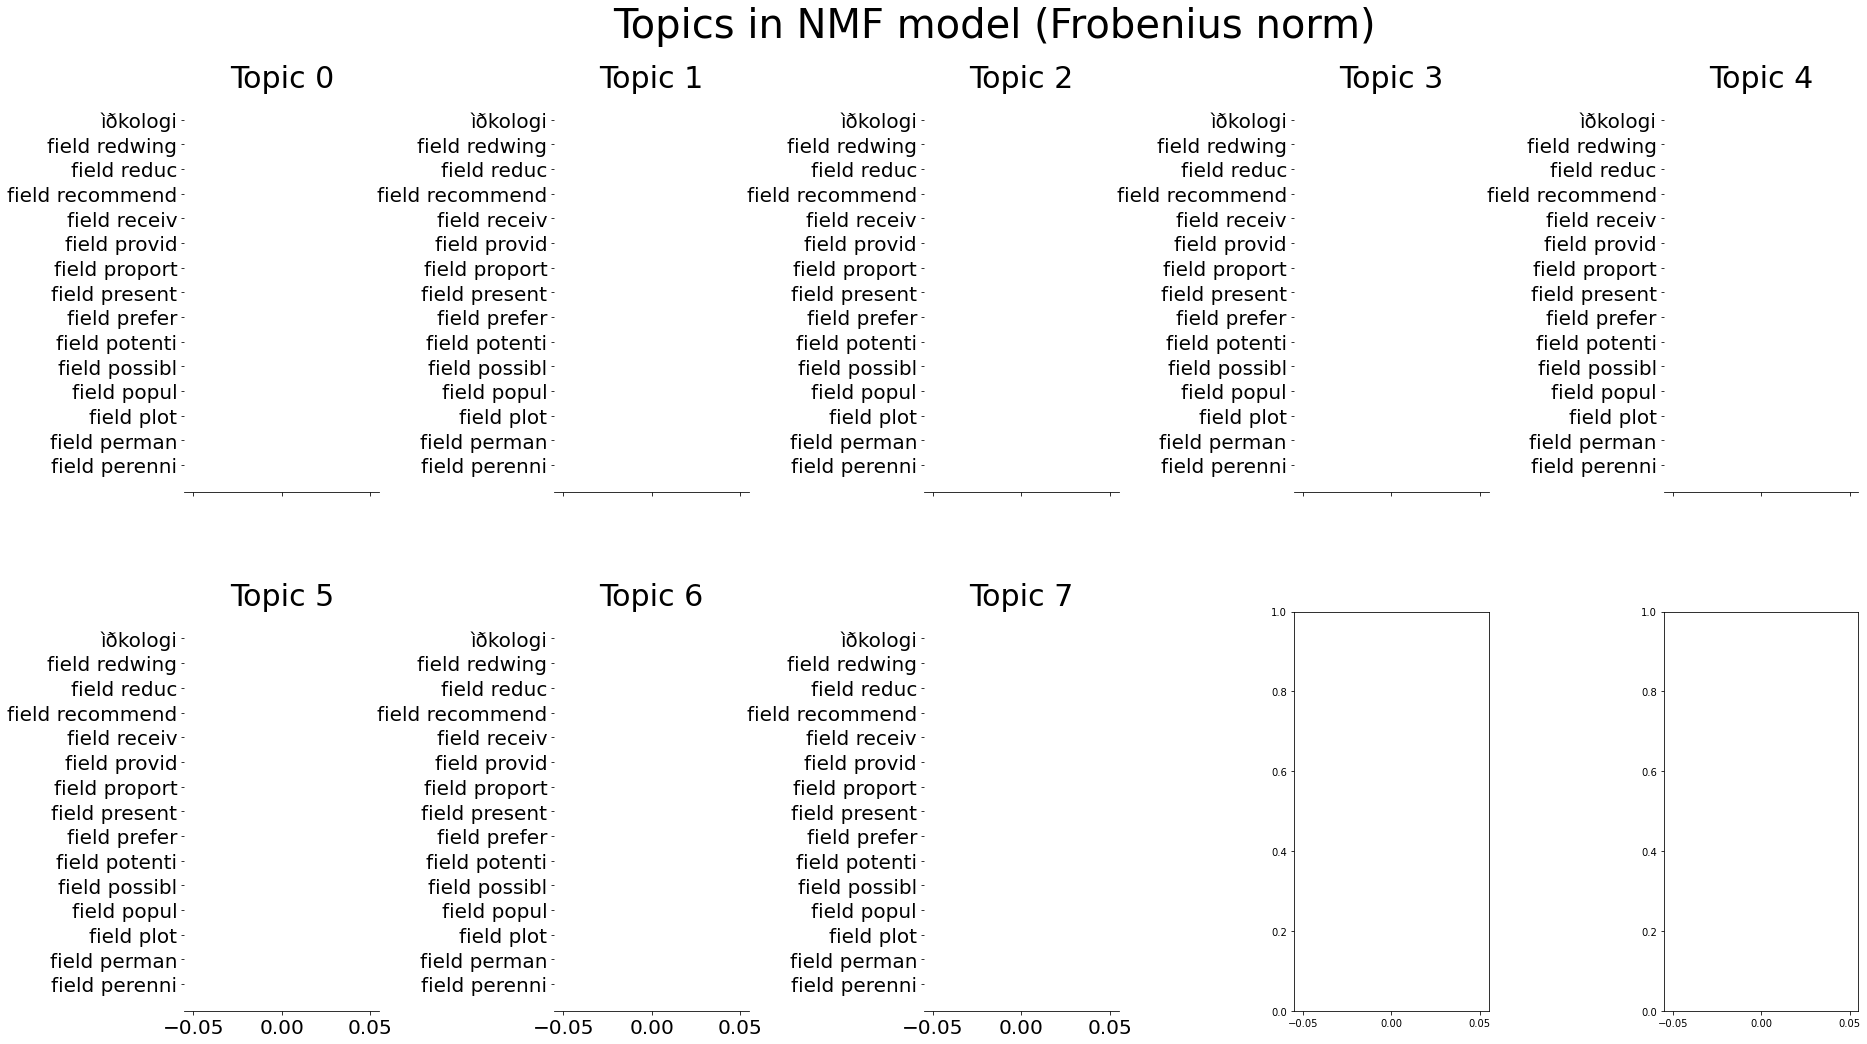

In [7]:
n_components = 8
n_top_words = 15

# He we define our model and its parameters
nmf = NMF(n_components=n_components, random_state=1, alpha_W=0.1, l1_ratio=0.5)

# Now we fit the model on the data and return the document-topic matrix we call W
W = nmf.fit_transform(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# We save the results as csvs
np.savetxt(f"tm-results/nmf_W_{n_components}.csv", W, delimiter=",")
np.savetxt(f"tm-results/nmf_H_{n_components}.csv", nmf.components_, delimiter=",")
np.savetxt(f"tm-results/features_{n_components}.csv", tfidf_feature_names, delimiter = ",", fmt='%s')

# Now we plot the topic words
t_titles = plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)", n_components
)

In [ ]:
n_components = 19
n_top_words = 15

# He we define our model and its parameters
nmf = NMF(n_components=n_components, random_state=1, alpha_W=0.1, l1_ratio=0.5)

# Now we fit the model on the data and return the document-topic matrix we call W
W = nmf.fit_transform(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# We save the results as csvs
np.savetxt(f"tm-results/nmf_W_{n_components}.csv", W, delimiter=",")
np.savetxt(f"tm-results/nmf_H_{n_components}.csv", nmf.components_, delimiter=",")
np.savetxt(f"tm-results/features_{n_components}.csv", tfidf_feature_names, delimiter = ",", fmt='%s')

# Now we plot the topic words
t_titles = plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)", n_components
)

In [ ]:
n_components = 25
n_top_words = 15

# He we define our model and its parameters
nmf = NMF(n_components=n_components, random_state=1, alpha=0.1, l1_ratio=0.5)

# Now we fit the model on the data and return the document-topic matrix we call W
W = nmf.fit_transform(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# We save the results as csvs
np.savetxt(f"tm-results/nmf_W_{n_components}.csv", W, delimiter=",")
np.savetxt(f"tm-results/nmf_H_{n_components}.csv", nmf.components_, delimiter=",")
np.savetxt(f"tm-results/features_{n_components}.csv", tfidf_feature_names, delimiter = ",", fmt='%s')

# Now we plot the topic words
t_titles = plot_top_words(
    nmf, tfidf_feature_names, n_top_words, "Topics in NMF model (Frobenius norm)", n_components
)

In [ ]:
# Here's a quick function to get the documents most associated with a given topic

def get_topic_docs(W, t_index, n_docs):
    dids = np.argsort(W[t_index,:])[::-1][:n_docs]
    for did in dids:
        print()
        print(df['Abstract'][did])
        
# This prints the 1 document most associated with topic 5
get_topic_docs(W, 5, 1)


## Dimensionality reduction with UMAP

Our doc-topic matrix is still hard to plot because it has `n_components` dimensions. We can use UMAP to reduce this to two dimensions, while maintaining the local and (to some extent) global structure of the multidimensional data

In [ ]:
import umap
print(W.shape)
reducer = umap.UMAP()
embedding = reducer.fit_transform(W)
print(embedding.shape)
fig, ax = plt.subplots(figsize=(7,5.7),dpi=125)

ax.scatter(
    embedding[:,0], embedding[:,1], 
    c=df.Pub_Year, cmap='YlGn', 
    alpha=0.7, s=8,
    lw=0.5, ec="grey"
)

In [ ]:
# Now we want to plot this, add topic labels, and use some other aspect of the data to decide the colour of the points

# We import a couple more libraries
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
import mpld3
from adjustText import adjust_text

# Initiate a figure object
fig, ax = plt.subplots(figsize=(7,5.7),dpi=150)

# Make a scatter plot with the dimensions of the embedding as X and Y arguments, and the publication year as the colour
scatter = ax.scatter(
    embedding[:,0], embedding[:,1], 
    c=df.Pub_Year, cmap='YlGn', 
    alpha=0.7, s=8,
    lw=0.5, ec="grey"
)

# This function takes a set of points associated with a given topic label, and adds that label in the center of each cluster of points that are found
def cluster_label_points(
    title, points, ax, eps,
    min_cluster, clabel_size,
    ):
    
    # cluster the points and get the cluster numbers of the points
    db = DBSCAN(eps=eps,min_samples=min_cluster).fit(points)
    labels = db.labels_
    texts = []
    
    # For each cluster number
    for l in set(labels):
        # ignore the -1 cluster which is the remainder which cannot be clustered
        if l==-1:
            continue
        
        # get the indices of the points which have this cluster label
        ind = np.argwhere(labels==l).ravel()
        # The label points are those points with those indices
        lpoints = points[ind]
        # As long as the cluster is bigger than the min_cluster parameter, add a label
        if len(ind) > min_cluster:
            # Get the smallest shape that can be drawn around the point
            hull = ConvexHull(lpoints)
            # Get the center of that shape
            cx = np.mean(hull.points[hull.vertices,0])
            cy = np.mean(hull.points[hull.vertices,1])
            c = [cx,cy]
            # Get a short form of the title (just the first term)
            title = title.split(",")[0].replace("{","")
            # Add the label to the plot
            text = ax.annotate(
                title, c, fontsize=clabel_size,
                ha="center",va="center",
                bbox={'facecolor':"white", 'alpha':0.4, 'pad':0.2, 'boxstyle': 'round'}

            )
            texts.append(text)
    return texts
            
# Set a couple of parameters for the plotting
min_cluster = 5
# eps is a parameter for dbscan: the maximum distance between two samples for them to be considered part of the same neighbourhood
eps = 1
# The font size for the cluster label
clabel_size = 12
# The quantile of doctopic scores for documents to be considered part of a topic
t_thresh = 0.8

# start an empty list of labels, so we can run adjust_text to prevent them overlapping
texts = []

# for each topic
for t_index, title in enumerate(t_titles):
    # Get the nonzero topic scores
    scores = W[:,t_index][W[:,t_index].nonzero()]
    # then get the threshold from those scores given the quantile parameter set above 
    thresh = np.quantile(scores, t_thresh)
    # Get the indices of the documents above that threshold
    highlight_docs = np.argwhere(W[:,t_index]>thresh).ravel()
    # Get the points with those indices
    points = embedding[highlight_docs]
    # label the topic using the function defined above
    texts += cluster_label_points(
        title,
        points,
        ax,
        eps,
        min_cluster,
        clabel_size
    )
    
# Adjust the texts to prevent overlap
adjust_text(texts,ax=ax, arrowprops=dict(arrowstyle="->", color='None', lw=0.5))

    
# add gridlines  
ax.grid(linestyle='-')
# set x and y to be equal sizes
ax.axis('equal')

# Make a quick interactive version and save that to html
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=list(df['Title']))
mpld3.plugins.connect(fig, tooltip)
with open(f'tm-results/plots/nmf_{n_components}.html','w') as f:
    mpld3.save_html(fig,f)
    
# produce a legend with a cross section of colours from the scatter
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend2 = ax.legend(
    handles, labels, 
    loc="lower right", 
    #bbox_to_anchor=(1.2,0.8),
    title="Pub Year"
)

plt.savefig(f'tm-results/plots/nmf_{n_components}.pdf', bbox_inches="tight")
plt.savefig(f'tm-results/plots/nmf_{n_components}.png', dpi=150, bbox_inches="tight")


## We can also try some other methods for topic modelling, see below

In [ ]:
nmf = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha=0.1,
    l1_ratio=0.5,
).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
    n_components
)

In [ ]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model", n_components)